# 0. Imports

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt


# 1. IPD Setup

In [11]:

PAYOFF_MATRIX = np.array([
    [(3, 3), (0, 5)],  # (C, C), (C, D)
    [(5, 0), (1, 1)]   # (D, C), (D, D)
])

def always_cooperate(history):
  return 0

def always_defect(history):
  return 1

def tit_for_tat(history):
  #print(f"TFT history: {history}")
  if not history:
    return 0 # cooperate on first round
  else:
   # print(f"TFT last opponent move: {history[-1][0]}")
    return history[-1][0] # last opponent move

def suspicious_tit_for_tat(history):
  if not history:
    return 1 # defect on first round
  else:
    return history[-1][1] # last opponent move

def tit_for_two_tats(history):
    if len(history) < 2:
        return 0  # Cooperate on first two rounds
    if history[-1][0] == 1 and history[-2][0] == 1:
        return 1  # Defect if opponent defected in last two rounds
    else:
        return 0

def grim(history):
  if not history:
    return 0 # cooperate on first round
  else:
    if any(round[0] == 1 for round in history):
      return 1 # defect for the rest of the game if opponent has ever defected
    else:
      return 0

def pavlov(history):
  if not history:
    return 0 # cooperate on first round
  else:
    if history[-1][0] == history[-1][1]:
      return history[-1][1] # repeat last move if opponent made same move
    else:
      return 1 - history[-1][1] # opposite of last move

def random_move(history):
  return random.randint(0,1) # randomly choose to cooperate or defect

def play_ipd(ga_strategy, strategy2, num_rounds=75, noise_level=0.05):
    """Plays Iterated Prisoner's Dilemma and returns both players' scores."""
    history1 = []  # History for strategy1
    history2 = []  # History for strategy2
    score1, score2 = 0, 0

    for _ in range(num_rounds):
      move1 = ga_strategy.play(history2)
      move2 = strategy2(history1)

      # Introduce Noise (Noisy Execution)
      if random.random() < noise_level:
          move1 = 1 - move1
      if random.random() < noise_level:
          move2 = 1 - move2

      #Update the Histories, this has to be this order
      history1.append((move1,move2))
      history2.append((move1,move2))

      #print(f"History GA: {history1}")
      # print(f"Moves: {move1}, {move2}")

      # Get payoffs
      payoff = PAYOFF_MATRIX[move1][move2]
      score1 += payoff[0]
      score2 += payoff[1]

    return score1, score2  # Return scores for both players





# 2. GA Setup

In [12]:
def calculate_fitness_against_fixed_strategies(ga_strategy, fixed_strategies):
    """
    Play GA strategy against all fixed strategies to calculate fitness.
    Fitness can be scaled or averaged to ensure a more stable measure.
    """
    fitness = 0
    for strategy in fixed_strategies:
        score1, score2 = play_ipd(ga_strategy, strategy, num_rounds=75)
        fitness += score1
        # print(score1)
        # print(f"Score against {strategy.__name__}: {score1}")

    fitness = fitness / len(fixed_strategies)  # Average fitness
    return fitness



def tournament_selection(population, fixed_strategies, tournament_size=3):
    """
    Performs tournament selection on a population of IPD strategies.

    Args:
        population: A list of IPDStrategy objects.
        fixed_strategies: A list of fixed IPDStrategy objects to evaluate against.
        tournament_size: The number of individuals to include in each tournament.

    Returns:
        The winning IPDStrategy from the tournament.
    """
    tournament = random.sample(population, tournament_size)
    tournament_fitnesses = [calculate_fitness_against_fixed_strategies(individual, fixed_strategies) for individual in tournament]
    winner = tournament[tournament_fitnesses.index(max(tournament_fitnesses))]
    return winner


In [13]:
# GA Strategy Representation

class IPDStrategy:
    def __init__(self, memory_length, cooperation_probability, forgiveness_chance, punish_defect, first_move, mutation_rate=0.05):
        self.memory_length = memory_length
        self.cooperation_probability = cooperation_probability
        self.forgiveness_chance = forgiveness_chance
        self.mutation_rate = mutation_rate  # mutation rate should likely stay
        self.punish_defect = punish_defect
        self.first_move = first_move

    def __repr__(self):
        return f"IPDStrategy(first_move={self.first_move}, memory_length={self.memory_length}, cooperation_probability={self.cooperation_probability}, " \
               f"forgiveness_chance={self.forgiveness_chance}, punish_defect={self.punish_defect})"

    def mutate(self):
        """Perform mutation based on the mutation rate."""
        if random.random() < self.mutation_rate:
            # Randomly mutate one of the parameters
            mutation_choice = random.choice(['first_move', 'memory_length', 'cooperation_probability', 'forgiveness_chance', 'punish_defect'])
            if mutation_choice == 'first_move':
                self.first_move = random.choice([0, 1])
            elif mutation_choice == 'memory_length':
                self.memory_length = random.randint(1, 10)  # Mutate memory length from 0-10
            elif mutation_choice == 'cooperation_probability':
                self.cooperation_probability = random.uniform(0, 1)  # Mutate between 0 and 1
            elif mutation_choice == 'forgiveness_chance':
                self.forgiveness_chance = random.uniform(0, 1)
            elif mutation_choice == 'punish_defect':
                self.punish_defect = not self.punish_defect  # Flip punish_defect behavior

    def play(self, history):
        """Implement strategy logic for the current move, given the history."""
        if not history:
            return self.first_move  # Use the first move if no history

        # Limit the history to the memory length
        relevant_history = history[-self.memory_length:]

        # Check if the opponent has defected in the relevant history
        defect = False
        if self.punish_defect and any(round[1] == 1 for round in relevant_history):
            defect = True

        #Implement the 'Punish Defect' model.
        if defect:
            #If the model is defected, it should defect unless it forgives the opponent
            if random.random() > self.forgiveness_chance:
                return 1 #Defect to punish

        if random.random() < self.cooperation_probability:
            return 0  # Cooperate with the defined probability
        else:
            return 1  # Otherwise, defect

def crossover(parent1, parent2):
    """
    Perform crossover between two parent strategies to produce a child strategy.
    Averages the continuous attributes and keeps `first_move` and `punish_defect`.

    :param parent1: First parent strategy
    :param parent2: Second parent strategy
    :param weight: Weight used for averaging (default is 0.5 for a simple average)
    :return: A new child strategy
    """

    # Keep `first_move` and `punish_defect` unchanged from one parent
    first_move = random.choice([parent1.first_move, parent2.first_move])
    punish_defect = random.choice([parent1.punish_defect, parent2.punish_defect])

    # Average numerical attributes
    cooperation_probability = (parent1.cooperation_probability + parent2.cooperation_probability) / 2
    forgiveness_chance = (parent1.forgiveness_chance + parent2.forgiveness_chance) / 2
    # Create a new child strategy with the selected or averaged attributes
    child = IPDStrategy(
        memory_length=2,
        cooperation_probability=cooperation_probability,
        forgiveness_chance=forgiveness_chance,
        punish_defect=punish_defect,
        first_move=first_move
    )

    return child

In [14]:
def run_ga2(population_size=75, num_generations=50, mutation_rate=0.02, crossover_rate=0.8, num_elites=1, tournament_size=8, evaluate_against_strategies=None, noise_level=0.0):
  """Runs a genetic algorithm for the Iterated Prisoner's Dilemma."""

  print(f"Running GA with population: {population_size}, num_generations={num_generations}, mutation_rate={mutation_rate}, "
        f"crossover_rate={crossover_rate}, num_elites={num_elites}, tournament_size={tournament_size}, noise_level={noise_level} \n "
        f"Evaluating against: {[s.__name__ for s in evaluate_against_strategies]}")

  # Initialize population
  population = [IPDStrategy(memory_length=2,
                            cooperation_probability=random.uniform(0, 1),
                            forgiveness_chance=random.uniform(0, 1),
                            punish_defect=random.choice([True, False]),
                            first_move=random.choice([0, 1]),
                            mutation_rate=mutation_rate)
                for _ in range(population_size)]

  # Store the best fitness for each generation
  fitness_history = []
  cooperation_probability_history = []
  forgiveness_chance_history = []

  # Initialize performance_history dictionary for each fixed strategy
  performance_history = {strategy.__name__: [] for strategy in evaluate_against_strategies}

  # GA loop
  for generation in range(num_generations):

      # Calculate fitness of each individual
      fitnesses = [calculate_fitness_against_fixed_strategies(individual, evaluate_against_strategies) for individual in population]

      # Find the best fitness in the current generation
      best_fitness = max(fitnesses)
      best_strategy = population[fitnesses.index(best_fitness)]
      fitness_history.append(best_fitness)

      # Store parameter values of the best strategy
      cooperation_probability_history.append(best_strategy.cooperation_probability)
      forgiveness_chance_history.append(best_strategy.forgiveness_chance)

      # Print the best fitness of the current generation
      print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

      # Evaluate the performance of the best strategy against each fixed strategy

      #Store the performance

      # Evaluate the performance of the best strategy against each fixed strategy
      strategy_performance = {}
      for fixed_strategy in evaluate_against_strategies:
          score1, score2 = play_ipd(best_strategy, fixed_strategy, num_rounds=75, noise_level=noise_level)
          strategy_performance[fixed_strategy.__name__] = score1  # Score of GA strategy

      # Store the performance
      for strategy_name, score in strategy_performance.items():
          performance_history[strategy_name].append(score)


      # Sort the population by fitness in descending order
      sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]

      # Select the elites
      elites = sorted_population[:num_elites]

      # Create a new population (Elitism + Crossover/Mutation)
      new_population = elites.copy()  # Start with the elites


      # Fill the rest of the population through crossover and mutation
      while len(new_population) < population_size:
          parent1 = tournament_selection(population, evaluate_against_strategies, tournament_size=tournament_size)  # Select from the *old* population
          parent2 = tournament_selection(population, evaluate_against_strategies, tournament_size=tournament_size)  # Select from the *old* population

          if random.random() < crossover_rate:
              child = crossover(parent1, parent2)
              child.mutate()
              new_population.append(child)
          else:
              new_population.append(random.choice([parent1, parent2]))  # Add a parent directly


      population = new_population

  # After GA loop, find the best strategy
  best_strategy = max(population, key=lambda x: calculate_fitness_against_fixed_strategies(x, evaluate_against_strategies))
  print("Best strategy found:", best_strategy)

  # Return the histories
  return fitness_history, cooperation_probability_history, forgiveness_chance_history


# !EXECUTE HERE

Running GA with population: 75, num_generations=50, mutation_rate=0.02, crossover_rate=0.8, num_elites=1, tournament_size=8, noise_level=0.1 
 Evaluating against: ['always_cooperate']
Generation 1: Best Fitness = 355.0
Generation 2: Best Fitness = 355.0
Generation 3: Best Fitness = 361.0
Generation 4: Best Fitness = 369.0
Generation 5: Best Fitness = 367.0
Generation 6: Best Fitness = 367.0
Generation 7: Best Fitness = 367.0
Generation 8: Best Fitness = 365.0
Generation 9: Best Fitness = 365.0
Generation 10: Best Fitness = 371.0
Generation 11: Best Fitness = 365.0
Generation 12: Best Fitness = 365.0
Generation 13: Best Fitness = 367.0
Generation 14: Best Fitness = 367.0
Generation 15: Best Fitness = 367.0
Generation 16: Best Fitness = 365.0
Generation 17: Best Fitness = 363.0
Generation 18: Best Fitness = 373.0
Generation 19: Best Fitness = 361.0
Generation 20: Best Fitness = 365.0
Generation 21: Best Fitness = 373.0
Generation 22: Best Fitness = 367.0
Generation 23: Best Fitness = 369

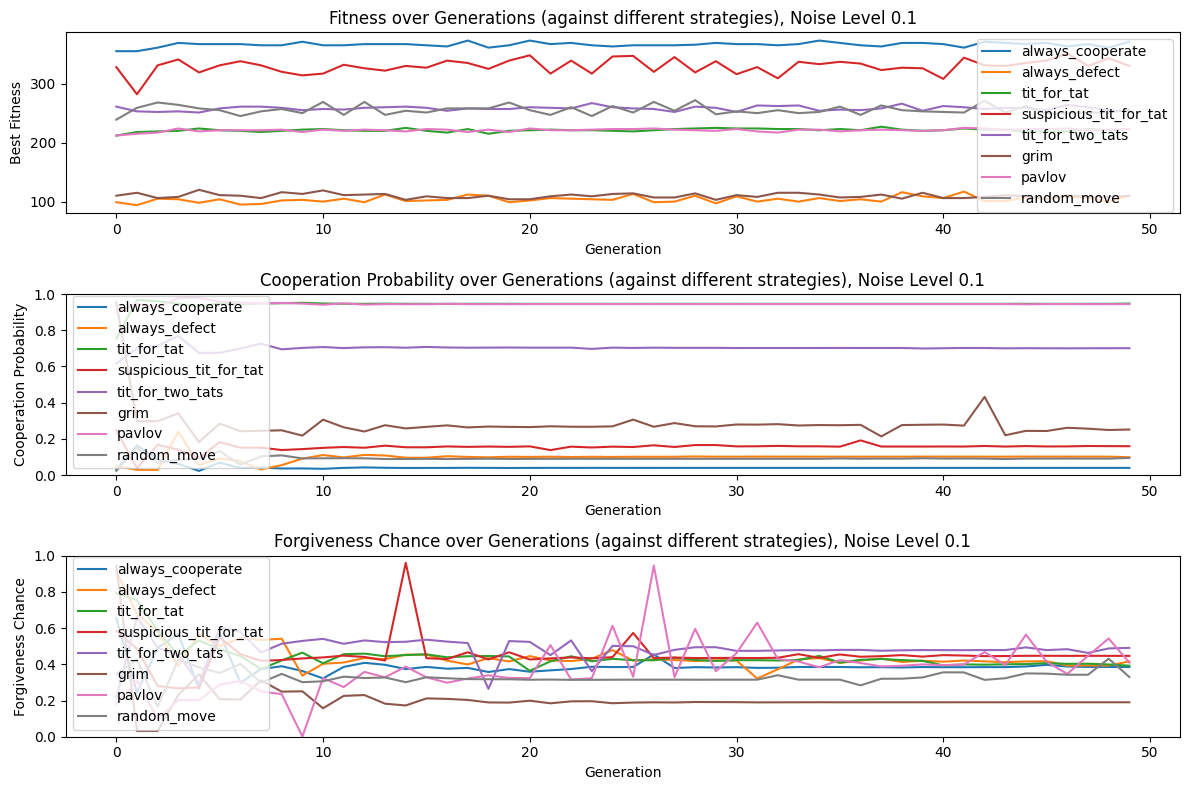

In [16]:
# ----- Parameters -----

# Define fixed strategies to evaluate against
FIXED_STRATEGIES = [
    always_cooperate,
    always_defect,
    tit_for_tat,
    suspicious_tit_for_tat,
    tit_for_two_tats,
    grim,
    pavlov,
    random_move
]

# Define noise level
noise_level = 0.1

# ----- Results and Plotting -----

# Store results
results = {}

# Run GA with default parameters
for strategy in FIXED_STRATEGIES:
    results[strategy.__name__] = run_ga2(evaluate_against_strategies=[strategy], noise_level=noise_level)

# Plotting
plt.figure(figsize=(12, 8))

# Fitness
plt.subplot(3, 1, 1)
for strategy_name, (fitness_history, _, _) in results.items():
    plt.plot(fitness_history, label=strategy_name)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title(f"Fitness over Generations (against different strategies), Noise Level {noise_level}")
plt.legend()

# Cooperation Probability
plt.subplot(3, 1, 2)
for strategy_name, (_, cooperation_probability_history, _) in results.items():
    plt.plot(cooperation_probability_history, label=strategy_name)
plt.xlabel("Generation")
plt.ylabel("Cooperation Probability")
plt.title(f"Cooperation Probability over Generations (against different strategies), Noise Level {noise_level}")
plt.ylim(0.0, 1.0)  # Scale the y-axis
plt.legend()

# Forgiveness Chance
plt.subplot(3, 1, 3)
for strategy_name, (_, _, forgiveness_chance_history) in results.items():
    plt.plot(forgiveness_chance_history, label=strategy_name)
plt.xlabel("Generation")
plt.ylabel("Forgiveness Chance")
plt.title(f"Forgiveness Chance over Generations (against different strategies), Noise Level {noise_level}")
plt.ylim(0.0, 1.0)  # Scale the y-axis
plt.legend()

plt.tight_layout()
plt.show()